### Задание:
Был проведен эксперимент с 2025-02-21 по 2025-02-27 включительно. Для эксперимента были задействованы 2 и 1 группы. В группе 2 был использован один из новых алгоритмов рекомендации постов (Рекомендации "похожих на лайкнутые постов"), группа 1 использовалась в качестве контроля. Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. Нужно проанализировать данные А/B-теста.

In [2]:
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import pandahouse

In [3]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20250320'
}

q = """
SELECT exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) between '2025-02-21' and '2025-02-27'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

In [6]:
df.exp_group.value_counts()

exp_group
1    10020
2     9877
Name: count, dtype: int64

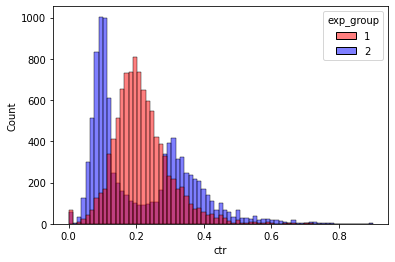

In [5]:
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Распределение CTR в группе 2 двумодальное, это означает, что алгоритм по-разному повлиял на подгруппы пользователей.

In [4]:
group_A = df[df.exp_group == 1].copy()
group_B = df[df.exp_group == 2].copy()

In [10]:
#T-тест

_, p_value = stats.ttest_ind(group_A.ctr, group_B.ctr, equal_var=False)
print(f'p-value = {p_value}')

p-value = 0.685373331140751


Полученное значение p-value выше 0.05, значит мы не можем отбросить нулевую гипотезу, которая заключается в том, что CTR двух групп равны. Но из графика видно, что CTR в двух группах сильно отличается. Это противоречие возникло из-за нарушения условий применения t-теста — данные экспериментальной группы имеют два пика, а не нормальное распределение. Поэтому t-тест здесь не подходит, и нужны другие методы анализа.

In [12]:
# Манна-Уитни

_, p_value = stats.mannwhitneyu(group_A.ctr, group_B.ctr, alternative = 'two-sided')
print(f'p-value = {p_value}')

p-value = 4.632205841806026e-45


Тест Манна-Уитни выявил статистически значимые различия в CTR между группами (p < 0.0001). Новый алгоритм существенно повлиял на метрику.

In [11]:
# t-тест на сглаженном ctr (α=5)

def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

global_ctr_1 = group_A.likes.sum()/group_A.views.sum()
global_ctr_2 = group_B.likes.sum()/group_B.views.sum()

group_A['smothed_ctr'] = group_A.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)
group_B['smothed_ctr'] = group_B.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

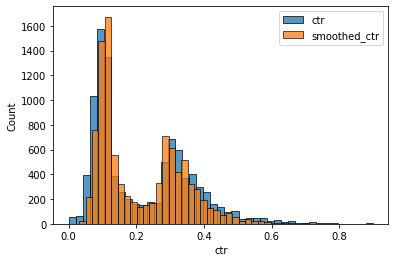

In [12]:
sns.histplot(group_B.ctr, label='ctr')
sns.histplot(group_B.smothed_ctr, label='smoothed_ctr')
plt.legend()

In [22]:
_, p_value = stats.ttest_ind(group_A.smothed_ctr, group_B.smothed_ctr, equal_var=False)
print(f'p-value = {p_value}')

p-value = 0.05166679015318526


 Алгоритм сглаживания мог по-разному повлиять на подгруппы пользователей, что привело к p-value ≈ 0.051. Формально это значение не достигает стандартного уровня значимости 0.05, но крайне близкое к нему, но это не подтверждает стабильный положительный эффект на всю популяцию.

In [7]:
# Пуассоновский бутстреп

def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

likes1 = group_A.likes.to_numpy()
views1 = group_A.views.to_numpy()
likes2 = group_B.likes.to_numpy()
views2 = group_B.views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

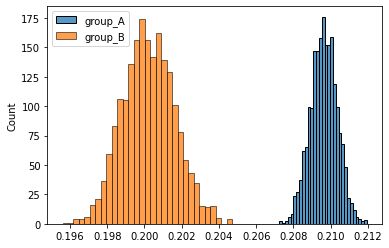

In [9]:
sns.histplot(ctr1, label='group_A')
sns.histplot(ctr2, label='group_B')
plt.legend()

Глобальный CTR ниже в тестовой группе, то есть новый алгоритм рекомендации постов негативно повлиял на глобальный CTR

In [4]:
# Бакетное преобразование

q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2025-02-21' and '2025-02-27'
    and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df = pandahouse.read_clickhouse(q, connection=connection)

In [8]:
group_A = df[df.exp_group == 1].copy()
group_B = df[df.exp_group == 2].copy()

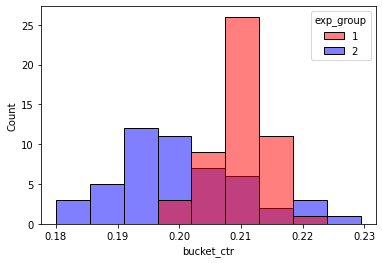

In [9]:
groups = sns.histplot(data = df, 
              x='bucket_ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [6]:
#T-тест

_, p_value = stats.ttest_ind(group_A.bucket_ctr, group_B.bucket_ctr, equal_var=False)
print(f'p-value = {p_value}')

p-value = 4.592644937473873e-07


In [7]:
# Манна-Уитни

_, p_value = stats.mannwhitneyu(group_A.bucket_ctr, group_B.bucket_ctr, alternative = 'two-sided')
print(f'p-value = {p_value}')

p-value = 2.6576427804010095e-07


Оба теста (и t-test, и Манна-Уитни) хорошо улавливают разницу между группами. T-test после бакетного преобразования сработал лучше, поскольку распределение стало больше похоже на нормальное.

**Вывод:** Новый алгоритм рекомендаций дал противоречивые результаты. У части пользователей CTR вырос — им нравятся похожие посты. Но у другой группы вовлечённость упала — вероятно, им быстро наскучил однотипный контент. Общий CTR в тестовой группе снизился. Это видно и по бутстреп-анализу, и по графикам. Алгоритм рискует отпугнуть часть аудитории.

**Заключение:** внедрять текущую версию не стоит. Нужен доработанный алгоритм, который сочетает персонализацию с разнообразием контента. Иначе мы потеряем пользователей, которым важна новизна.